<a href="https://colab.research.google.com/github/ShravyaMalogi/floor_segmentation/blob/main/floor_weights.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
!pip install tensorflow opencv-python matplotlib numpy albumentations

In [16]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

In [17]:
import tensorflow as tf
from tensorflow.keras.layers import (
    Input,
    Conv2D,
    MaxPooling2D,
    UpSampling2D,
    Concatenate
)
from tensorflow.keras.models import Model

In [18]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("deepakmedam/corridor-floor-segmentation")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'corridor-floor-segmentation' dataset.
Path to dataset files: /kaggle/input/corridor-floor-segmentation


In [19]:
!ls /root/.cache/kagglehub/datasets/deepakmedam/corridor-floor-segmentation/versions/1/corridor/

BlendedData  ground_truth  raw_image


In [20]:
IMG_SIZE = 256

def load_data(image_dir, mask_dir):
    images = []
    masks = []

    for img_file in os.listdir(image_dir):

        img_path = os.path.join(image_dir, img_file)

        base = img_file.split(".")[0]          # frame_001
        mask_file = base + "_mask.png"         # frame_001_mask.png
        mask_path = os.path.join(mask_dir, mask_file)

        if not os.path.exists(mask_path):
            continue

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img = img / 255.0

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (IMG_SIZE, IMG_SIZE))
        mask = mask / 255.0
        mask = (mask > 0.5).astype("float32")
        mask = np.expand_dims(mask, axis=-1)

        images.append(img)
        masks.append(mask)

    return np.array(images), np.array(masks)


In [21]:
IMAGE_DIR = "/root/.cache/kagglehub/datasets/deepakmedam/corridor-floor-segmentation/versions/1/corridor/raw_image"
MASK_DIR  = "/root/.cache/kagglehub/datasets/deepakmedam/corridor-floor-segmentation/versions/1/corridor/ground_truth"

X, Y = load_data(IMAGE_DIR, MASK_DIR)

print("Images:", X.shape)
print("Masks:", Y.shape)

Images: (238, 256, 256, 3)
Masks: (238, 256, 256, 1)


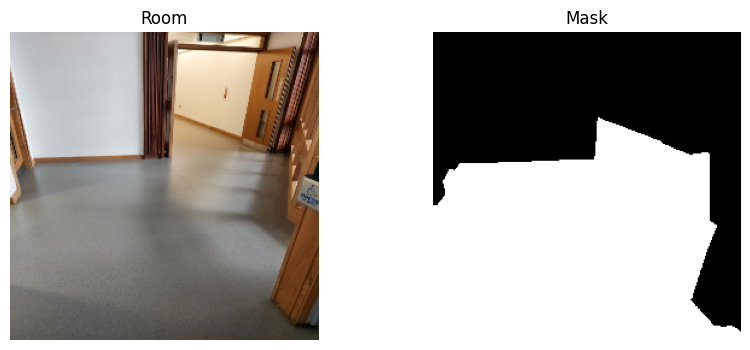

In [22]:
import matplotlib.pyplot as plt

i = 5

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.title("Room")
plt.imshow(X[i])
plt.axis("off")

plt.subplot(1,2,2)
plt.title("Mask")
plt.imshow(Y[i].squeeze(), cmap="gray")
plt.axis("off")

plt.show()

# Segmentation Improvement


In [23]:
Y = (Y > 0.5).astype("float32")

In [24]:
print(type(Y))
print(Y.shape)

<class 'numpy.ndarray'>
(238, 256, 256, 1)


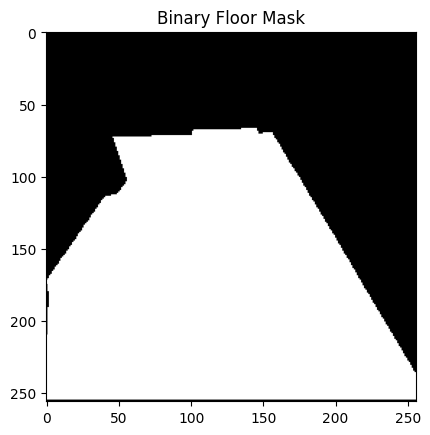

In [25]:
import matplotlib.pyplot as plt

plt.imshow(Y[0].squeeze(), cmap="gray")
plt.title("Binary Floor Mask")
plt.show()

In [26]:
X_train, X_val, Y_train, Y_val = train_test_split(
    X, Y, test_size=0.2, random_state=42
)

In [27]:
def unet():
    inputs = Input((256,256,3))

    c1 = Conv2D(64,3,activation='relu',padding='same')(inputs)
    c1 = Conv2D(64,3,activation='relu',padding='same')(c1)
    p1 = MaxPooling2D()(c1)

    c2 = Conv2D(128,3,activation='relu',padding='same')(p1)
    c2 = Conv2D(128,3,activation='relu',padding='same')(c2)
    p2 = MaxPooling2D()(c2)

    c3 = Conv2D(256,3,activation='relu',padding='same')(p2)
    c3 = Conv2D(256,3,activation='relu',padding='same')(c3)

    u4 = UpSampling2D()(c3)
    u4 = Concatenate()([u4, c2])
    c4 = Conv2D(128,3,activation='relu',padding='same')(u4)

    u5 = UpSampling2D()(c4)
    u5 = Concatenate()([u5, c1])
    c5 = Conv2D(64,3,activation='relu',padding='same')(u5)

    outputs = Conv2D(1,1,activation='sigmoid')(c5)

    return Model(inputs, outputs)

In [28]:
model = unet()

model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=30,
    batch_size=8
)

Epoch 1/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 15s 372ms/step - accuracy: 0.5839 - loss: 0.6465 - val_accuracy: 0.8142 - val_loss: 0.4867
Epoch 2/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 236ms/step - accuracy: 0.8051 - loss: 0.4687 - val_accuracy: 0.8543 - val_loss: 0.3467
Epoch 3/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 238ms/step - accuracy: 0.8636 - loss: 0.3428 - val_accuracy: 0.8685 - val_loss: 0.3181
Epoch 4/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 240ms/step - accuracy: 0.8847 - loss: 0.2825 - val_accuracy: 0.9022 - val_loss: 0.2777
Epoch 5/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 240ms/step - accuracy: 0.8945 - loss: 0.2864 - val_accuracy: 0.7687 - val_loss: 0.4422
Epoch 6/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 240ms/step - accuracy: 0.8590 - loss: 0.3185 - val_accuracy: 0.9175 - val_loss: 0.2164
Epoch 7/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 240ms/step - accuracy: 0.8948 - loss: 0.2599 - val_accuracy: 0.9118 - val_loss: 0.2341
Epoch 8/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 239ms/step - accuracy: 0.9000 - loss: 0.2493 - val_accuracy: 0

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


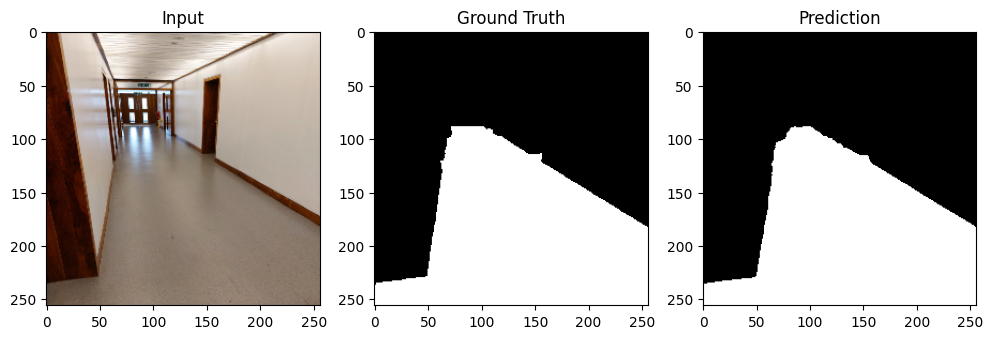

In [29]:
idx = 2

pred = model.predict(X_val[idx:idx+1])[0]
mask = (pred > 0.5).astype("uint8")

plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(X_val[idx])
plt.title("Input")

plt.subplot(1,3,2)
plt.imshow(Y_val[idx].squeeze(), cmap="gray")
plt.title("Ground Truth")

plt.subplot(1,3,3)
plt.imshow(mask.squeeze(), cmap="gray")
plt.title("Prediction")
plt.show()

# Fine-tune

In [30]:
kernel = np.ones((5,5), np.uint8)
mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)

In [31]:
contours, _ = cv2.findContours(
    mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
)

floor_contour = max(contours, key=cv2.contourArea)

epsilon = 0.02 * cv2.arcLength(floor_contour, True)
floor_poly = cv2.approxPolyDP(floor_contour, epsilon, True)

print("Polygon points:", len(floor_poly))

Polygon points: 6


In [32]:
def order_points(pts):
    pts = pts.reshape(4,2)
    rect = np.zeros((4,2), dtype="float32")

    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]

    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]

    return rect

In [35]:
texture = cv2.imread("/content/texture.jpg")
texture = cv2.cvtColor(texture, cv2.COLOR_BGR2RGB)

# Fix: Use cv2.minAreaRect to get exactly 4 points for the floor polygon
rect = cv2.minAreaRect(floor_contour)
box = cv2.boxPoints(rect)
floor_poly_fixed = np.float32(box)

dst = order_points(floor_poly_fixed)

src = np.array([
    [0,0],
    [texture.shape[1],0],
    [texture.shape[1],texture.shape[0]],
    [0,texture.shape[0]]
], dtype="float32")

h, w, _ = X_val[idx].shape

H, _ = cv2.findHomography(src, dst)
warped_texture = cv2.warpPerspective(texture, H, (w,h))

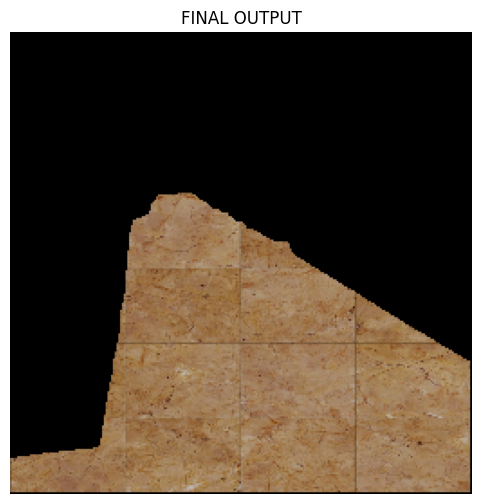

In [37]:
mask_3c = np.repeat(np.expand_dims(mask, axis=-1), 3, axis=2)

result = X_val[idx] * (1 - mask_3c) + warped_texture * mask_3c
result = result.astype("uint8")

plt.figure(figsize=(6,6))
plt.imshow(result)
plt.title("FINAL OUTPUT")
plt.axis("off")
plt.show()

In [39]:
model.save("floor_seg.keras")

In [41]:
from google.colab import files
files.download("floor_seg.keras")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>